In [1]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from proteus.visu import matrix as visu
from proteus.matrix import tseries as ts
import nibabel as nib
from nibabel.affines import apply_affine
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from nilearn.masking import compute_epi_mask
from nibabel.affines import apply_affine

/home/cdansereau/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
subj_id='HC0040123'

In [293]:
# original subject from pierre exp
covar = pd.read_csv('/home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/resample/fmri_'+subj_id+'_session1_run1_n_confounds.tsv.gz',sep='\t')
covar.columns
vol_nii = nib.load('/home/cdansereau/data/deepmotion/cobre/xp_2016_07_27_final/rest_'+subj_id+'.nii.gz')


In [294]:
vol = vol_nii.get_data()
Xmotion = covar.iloc[:,0:6].values
Xdrift  = covar.iloc[:,8:14].values
fd = covar['FD'].values

In [5]:
ls /home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/intermediate/HC0040123/motion_correction/

motion_parameters_HC0040123_session1_run1.mat
motion_target_HC0040123_session1_run1.nii.gz
motion_Wrun_HC0040123_session1_run1.mat


In [295]:
dat=sio.loadmat('/home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/intermediate/'+subj_id+'/motion_correction/motion_Wrun_'+subj_id+'_session1_run1.mat')
dat_parameters=sio.loadmat('/home/cdansereau/data/deepmotion/cobre/cobre_fmri_preprocess_nii_20161003/intermediate/'+subj_id+'/motion_correction/motion_parameters_'+subj_id+'_session1_run1.mat')

ln_motion_affine = dat['transf']
#ln_parameters_affine = dat_parameters['transf']

In [7]:
import numpy.linalg as npl
epi_vox2anat_vox = npl.inv(vol_nii.affine).dot(ln_motion_affine[...,0])
#apply_affine(dat['transf'][...,0], vol)


In [8]:
vol_nii.affine

array([[  3.74900937e+00,   0.00000000e+00,   1.04574092e-01,
         -1.17579018e+02],
       [  4.89537641e-02,   3.08637333e+00,  -2.58368921e+00,
         -3.95849724e+01],
       [ -7.09352046e-02,   2.12997651e+00,   3.74381042e+00,
         -1.07464394e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [9]:
ln_motion_affine[...,0]

array([[ 0.99990755, -0.00489232, -0.01268803, -0.80346918],
       [ 0.00477247,  0.99994385, -0.00945895,  0.20082903],
       [ 0.01273359,  0.00939753,  0.99987477, -1.95918894],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [92]:
ln_parameters_affine[...,0]

array([[ 0.99990755, -0.00489232, -0.01268803, -0.80346918],
       [ 0.00477247,  0.99994385, -0.00945895,  0.20082903],
       [ 0.01273359,  0.00939753,  0.99987477, -1.95918894],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [128]:
epi_vox2anat_vox[:,:,0]

array([[-24.59420037,   6.21882171, -60.6225368 ,  30.94184508],
       [-20.06162415,   5.23173224, -48.75769331,  24.96502554],
       [-12.11888898,   2.9035064 , -29.37934746,  15.08739372],
       [ -0.80346918,   0.20082903,  -1.95918894,   1.        ]])

In [140]:
npl.inv(vol_tmp.affine)

array([[  2.66596231e-01,   3.48116785e-03,  -5.04427328e-03,
          3.09418451e+01],
       [  1.42369357e-08,   2.19475422e-01,   1.51465009e-01,
          2.49650255e+01],
       [  5.05127818e-03,  -1.24800806e-01,   1.80838557e-01,
          1.50873937e+01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [141]:
vol_tmp.affine

array([[  3.74900937e+00,   0.00000000e+00,   1.04574092e-01,
         -1.17579018e+02],
       [  4.89537641e-02,   3.08637333e+00,  -2.58368921e+00,
         -3.95849724e+01],
       [ -7.09352046e-02,   2.12997651e+00,   3.74381042e+00,
         -1.07464394e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [10]:
from nilearn.image import resample_img
ii=1


vol_tmp = nib.Nifti1Image(vol.mean(3),vol_nii.affine)
#affine_trans = np.dot(vol_tmp.affine,ln_motion_affine)
#epi_vox2anat_vox = npl.inv(vol_tmp.affine).dot(ln_motion_affine)
tfm = [[1,0,0,  0],\
       [0,1,0,  0],\
       [0,0,1,-60],\
       [0,0,0,  1]]
new_img = resample_img(vol_tmp,np.dot(npl.inv(ln_motion_affine[:,:,ii]),(vol_nii.affine)),target_shape=vol_tmp.shape)

#new_img = resample_img(vol_tmp,target_affine=np.dot(tfm,vol_nii.affine),target_shape=vol_tmp.shape)


In [11]:
new_img.affine

array([[  3.74834536e+00,   3.76086050e-02,   1.27213553e-01,
         -1.18013409e+02],
       [  2.79862588e-02,   3.09857378e+00,  -2.56256433e+00,
         -3.97151108e+01],
       [ -1.07814404e-01,   2.11185390e+00,   3.75760351e+00,
         -1.03822451e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [ ]:
scipy.ndimage.map_coordinates

In [13]:
from scipy.interpolate import griddata
from nibabel.affines import apply_affine
import numpy.linalg as npl

values = np.zeros((10,10,10))*1.
values[2:4,2,2] = 1.

mm = np.mgrid[0:10,0:10,0:10]
#mm = mm.swapaxes(0,-1)[0,...]
#print mm.shape
vox_coord = mm.reshape((mm.shape[0],mm.shape[1]*mm.shape[2]*mm.shape[3])).T

#vox_2world_a = np.dot(npl.inv(ln_motion_affine[:,:,ii]),(vol_nii.affine))
translation_affine = np.array([[1, 0, 0, 1.5],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1]])
#scaling_affine = np.array([[ 3.   ,  0.   ,  0.   ,  0.   ],[ 0.   ,  2.866, -0.887,  0.   ],[ 0.   ,  0.887,  2.866,  0.   ],[ 0.   ,  0.   ,  0.   ,  1.   ]])
vox_2world_a = np.dot(translation_affine,vol_nii.affine)

target_aff = vol_nii.affine

#epi_vox2anat_vox = npl.inv(anat_img.affine).dot(epi_img.affine)

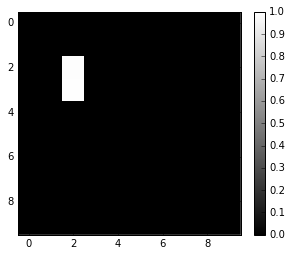

In [14]:
visu.mat(values[:,2,:])

(1000, 3) (10, 10, 10)
0.00139403343201
0.0753610134125


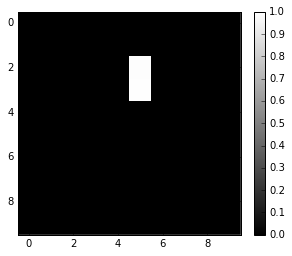

In [15]:
from scipy.interpolate import griddata
from nibabel.affines import apply_affine
import numpy.linalg as npl
import time


def resample_trans_ref(source_vol,source_affine,target_affine,target_shape,affine_trans=np.eye(4)):
    
    # source
    start = time.time()
    grid_source = np.mgrid[0:source_vol.shape[0],0:source_vol.shape[1],0:source_vol.shape[2]]
    vox_coord_vec = grid_source.reshape((grid_source.shape[0],grid_source.shape[1]*grid_source.shape[2]*grid_source.shape[3])).T
    vox_2world_a = np.dot(affine_trans,source_affine)
    
    points = apply_affine(vox_2world_a, vox_coord_vec)
    grid_ = apply_affine(target_affine, vox_coord_vec)
    print points.shape,values.shape
    
    print(time.time() - start)

    # target
    grid_target = np.mgrid[0:target_shape[0],0:target_shape[1],0:target_shape[2]]
    start = time.time()
    # interpolation to the grid
    grid_z1 = griddata(points, source_vol.ravel(), (grid_[...,0], grid_[...,1],grid_[...,2]), method='linear')
    grid_z1 = np.nan_to_num(grid_z1.reshape((source_vol.shape)))
    print(time.time() - start)
    return grid_z1

translation_affine = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 3],[0, 0, 0, 1]])
#dd = resample_trans_ref(values,vol_nii.affine,vol_nii.affine,values.shape,translation_affine)
dd = resample_trans_ref(values,np.eye(4),np.eye(4),values.shape,translation_affine)
visu.mat(dd[:,2,:])

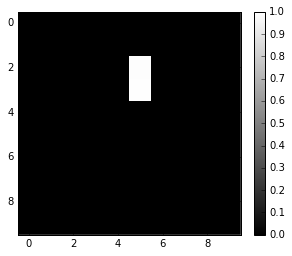

In [16]:
from scipy.interpolate import griddata
from nibabel.affines import apply_affine
import numpy.linalg as npl
import time
from nilearn.image import resampling
from scipy import ndimage
import numpy.linalg as npl
from scipy import ndimage

def resample_trans(sv,sv2sw_affine,tv2tw_affine,tv_shape,sw2tw_affine=np.eye(4)):
    
    # transform 
    #start = time.time()
    #transform_affine = np.dot(npl.inv(np.dot(sw2tw_affine,tv2tw_affine)), sv2sw_affine)
    #print transform_affine
    
    #transform_affine = np.dot(npl.inv(tv2tw_affine),np.dot(sw2tw_affine, sv2sw_affine))
    #print transform_affine
    
    transform_affine = npl.inv(np.dot(npl.inv(tv2tw_affine),np.dot(sw2tw_affine, sv2sw_affine)))
    #print transform_affine
    
    # Split an homogeneous transform into its matrix and vector components.
    # The transformation must be represented in homogeneous coordinates.
    # It is split into its linear transformation matrix and translation vector
    # components.
    
    ndimin = transform_affine.shape[0] - 1
    ndimout = transform_affine.shape[1] - 1
    matrix = transform_affine[0:ndimin, 0:ndimout]
    vector = transform_affine[0:ndimin, ndimout]
    #print matrix,vector
    
    # interpolation
    new_volume = ndimage.affine_transform(sv, matrix,
                             offset=vector,
                             output_shape=tv_shape,
                             order=1)
    #print(time.time() - start)
    return new_volume


translation_affine = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 3],[0, 0, 0, 1]])
#dd = resample_trans(values,vol_nii.affine,vol_nii.affine,values.shape,translation_affine)
dd = resample_trans(values,np.eye(4),np.eye(4),values.shape,translation_affine)
visu.mat(dd[:,2,:],lim=[0,1])

In [17]:
def aff_tsf(xt,yt,zt,xr,yr,zr):
    transf = np.eye(4)
    # translation
    transf[0,3] = xt
    transf[1,3] = yt
    transf[2,3] = zt
    ## rotation
    rot_x = np.eye(4)
    rot_y = np.eye(4)
    rot_z = np.eye(4)
    if xr !=0:
        rot_x = np.array([[1.,0.,0.,0.],[0.,np.cos(xr),-np.sin(xr),0.],[0.,np.sin(xr),np.cos(xr),0.],[0.,0.,0.,1.]]).astype(float)
    if yr !=0:
        rot_y = np.array([[np.cos(yr),0.,np.sin(yr),0.],[0.,1.,0.,0.],[-np.sin(yr),0.,np.cos(yr),0.],[0.,0.,0.,1.]]).astype(float)
    if zr !=0:
        rot_z = np.array([[np.cos(zr),-np.sin(zr),0.,0.],[np.sin(zr),np.cos(zr),0.,0.],[0.,0.,1.,0.],[0.,0.,0.,1.]]).astype(float)
    #print transf,rot_x,rot_y,rot_z
    
    return transf.dot(rot_x).dot(rot_y).dot(rot_z)
    
aff_tsf(5.,0.,0.,0.,0.5,0.)

array([[ 0.87758256,  0.        ,  0.47942554,  5.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [-0.47942554,  0.        ,  0.87758256,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

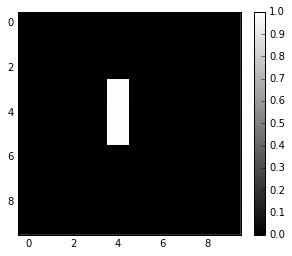

In [18]:
values = np.zeros((10,10,10))*1.
values[3:6,4,4] = 1.

#translation_affine = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 3],[0, 0, 0, 1]])
v2w_affine = np.array([[1, 0, 0, 4],[0, 1, 0, 4],[0, 0, 1, 4],[0, 0, 0, 1]])
ssss = [0.,0.,0.,0.,0.,0.]
translation_affine = aff_tsf(*ssss)
#dd = resample_trans(values,vol_nii.affine,vol_nii.affine,values.shape,translation_affine)
dd = resample_trans(values,v2w_affine,v2w_affine,values.shape,translation_affine)
visu.mat(dd[:,4,:],lim=[0,1])

[[ 0.70710678  0.          0.70710678  3.        ]
 [ 0.          1.          0.          0.        ]
 [-0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]]


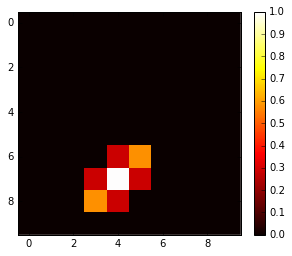

In [19]:
#translation_affine = np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 3],[0, 0, 0, 1]])
v2w_affine = np.array([[1, 0, 0, -4],[0, 1, 0, -4],[0, 0, 1, -4],[0, 0, 0, 1]])
ssss = [3.,0.,0.,0,np.pi/4,0]
translation_affine = aff_tsf(*ssss)
#dd = resample_trans(values,vol_nii.affine,vol_nii.affine,values.shape,translation_affine)
target = resample_trans(values,v2w_affine,v2w_affine,values.shape,translation_affine)
visu.mat(target[:,4,:],lim=[0,1])
print translation_affine

In [20]:
ssss = [1.,0.,1.,1.,0.,0.5]
aff_tsf(*ssss)

array([[ 0.87758256, -0.47942554,  0.        ,  1.        ],
       [ 0.25903472,  0.47415988, -0.84147098,  0.        ],
       [ 0.40342268,  0.73846026,  0.54030231,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [21]:
args=(target,values,np.eye(4),np.eye(4),values.shape)
resample_trans(*args,transf)

SyntaxError: only named arguments may follow *expression (<ipython-input-21-c040d1adf464>, line 2)

In [22]:
np.corrcoef(target.ravel(),values.ravel())

array([[ 1.        , -0.00408206],
       [-0.00408206,  1.        ]])

In [23]:
from scipy.optimize import fmin_powell
from scipy.spatial import distance
def aff_trans(params,*args):
    transf = aff_tsf(*params)
    coreg_vol = resample_trans(args[1],args[2],args[3],args[4],sw2tw_affine=transf)
    return coreg_vol

def coreg_(params,*args):
    coreg_vol = aff_trans(params,*args)
    #score = distance.euclidean(coreg_vol.ravel(),args[0].ravel())
    score = np.corrcoef(coreg_vol.ravel(),args[0].ravel())
    #print score
    #print score[0,1]
    #print x,args
    return 1-score[0,1]
    #return score

v2w_affine = np.array([[1, 0, 0, -4],[0, 1, 0, -4],[0, 0, 1, -4],[0, 0, 0, 1]])
#v2w_affine = np.eye(4)
aa=fmin_powell(coreg_,np.zeros((1,6))[0,:],args=(target,values,v2w_affine,v2w_affine,values.shape))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 22
         Function evaluations: 2475


In [29]:
from proteus.matrix import registration
reload(registration)

<module 'proteus.matrix.registration' from '/home/cdansereau/git/Proteus/proteus/matrix/registration.py'>

In [31]:
coreg_vol, transf, _ = registration.fit(values,v2w_affine,target,v2w_affine)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 22
         Function evaluations: 2475


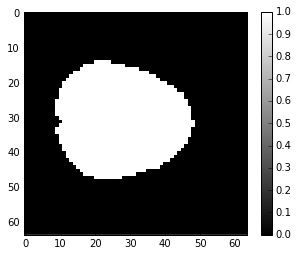

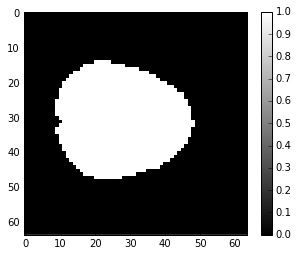

In [349]:
from nilearn.masking import compute_epi_mask
mask_b = compute_epi_mask(vol_nii).get_data().astype(bool)

plt.figure()
visu.mat(mask_b[:,:,20])

#mask_b = binary_dilation(mask_b,iterations=2)
plt.figure()
visu.mat(mask_b[:,:,20])

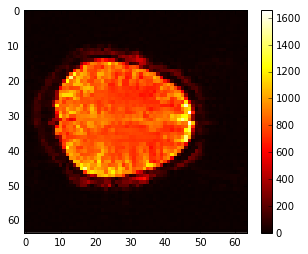

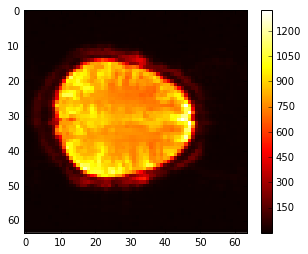

In [276]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_dilation

sss = gaussian_filter(vol_nii.get_data()[:,:,:,:],0.5,0)
plt.figure()
visu.mat(vol_nii.get_data()[:,:,:,0][:,:,20])
plt.figure()
visu.mat(sss[:,:,20,0])

In [387]:
reload(registration)
start = time.time()
coreg_vol, transf, params = registration.fit(vol_nii.get_data()[:,:,:,:],np.copy(vol_nii.get_affine()),np.median(vol_nii.get_data(),3),np.copy(vol_nii.get_affine()),mask=mask_b,dowsamp_flag=True)
#coreg_vol, transf, params = registration.fit(vol_nii.get_data()[:,:,:,0],np.copy(vol_nii.get_affine()),np.median(vol_nii.get_data(),3),np.copy(vol_nii.get_affine()),mask=mask_b,dowsamp_flag=True)
#coreg_vol, transf, params = registration.fit(vol_nii.get_data()[:,:,:,0],vol_nii.get_affine(),gaussian_filter(np.median(vol_nii.get_data(),3),0.5,0),vol_nii.get_affine(),mask_b,dowsamp_flag=True)
print(time.time() - start)

91.2554819584


In [336]:
tv2tw_affine = np.copy(vol_nii.get_affine())
print tv2tw_affine
tv_shape = np.ceil(np.array(np.median(vol_nii.get_data(),3).shape) / 2.)
tv2tw_affine[:3, :3] = tv2tw_affine[:3, :3] * 2.
#tv2tw_affine[0, 0] *= 2.
#tv2tw_affine[1, 1] *= 2.
#tv2tw_affine[2, 2] *= 2.
print tv2tw_affine


target_downsamp = registration.resample_trans(np.median(vol_nii.get_data(),3), np.copy(vol_nii.get_affine()),tv2tw_affine, tv_shape)

print np.median(vol_nii.get_data(),3).shape
print target_downsamp.shape

[[  3.74900937e+00   0.00000000e+00   1.04574092e-01  -1.17579018e+02]
 [  4.89537641e-02   3.08637333e+00  -2.58368921e+00  -3.95849724e+01]
 [ -7.09352046e-02   2.12997651e+00   3.74381042e+00  -1.07464394e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[  7.49801874e+00   0.00000000e+00   2.09148183e-01  -1.17579018e+02]
 [  9.79075283e-02   6.17274666e+00  -5.16737843e+00  -3.95849724e+01]
 [ -1.41870409e-01   4.25995302e+00   7.48762083e+00  -1.07464394e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
(64, 64, 33)
(32, 32, 17)


In [334]:
sssss.shape

(32, 32, 17)

In [353]:
reload(registration)
sssss = registration.fit(vol_nii.get_data()[:,:,:,0],np.copy(vol_nii.get_affine()),np.median(vol_nii.get_data(),3),np.copy(vol_nii.get_affine()),mask=mask_b,dowsamp_flag=True)

In [350]:
sssss = registration.resample_trans(mask_b, np.copy(vol_nii.get_affine()),tv2tw_affine, tv_shape)

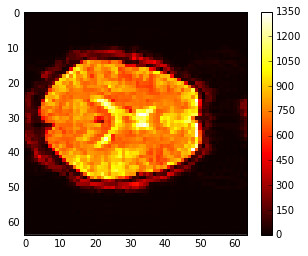

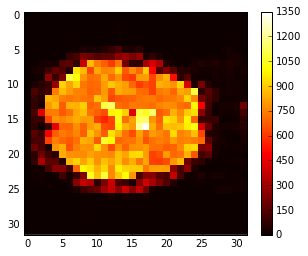

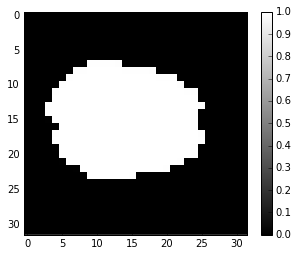

In [355]:
plt.figure()
visu.mat(np.median(vol_nii.get_data(),3)[:,:,16],lim=[0,1350])
plt.figure()
visu.mat(target_downsamp[:,:,8],lim=[0,1350])
plt.figure()
visu.mat(sssss[:,:,8],lim=[0,1])


In [239]:
np.rint(np.array([0.55,0.2,0.8])).astype(bool)

array([ True, False,  True], dtype=bool)

In [368]:
params_downsamp = params

In [222]:
params_downsamp_tuned = params

In [215]:
params_full = params

In [206]:
np.ceil(np.array(vol.shape)/2)

array([ 32.,  32.,  16.,  75.])

In [208]:
np.array(vol.shape)/2.

array([ 32. ,  32. ,  16.5,  75. ])

In [43]:
np.stack(coreg_vol,axis=3).shape

(64, 64, 33, 4)

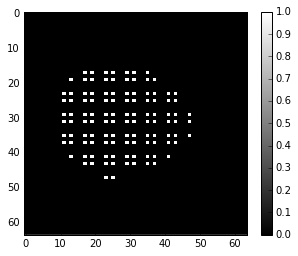

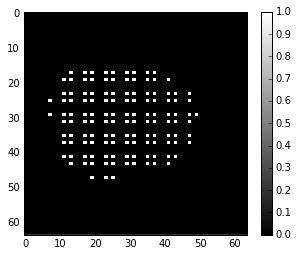

In [186]:
aa=np.array([1,2,3,4,5,6,7,8,9])

mask_ = mask_b.copy()
grid_mask = 
mask_[::2,:,:] = False
mask_[::3,:,:] = False
mask_[:,::2,:] = False
mask_[:,::3,:] = False


plt.figure()
visu.mat(mask_[:,:,20])
mask_[2::2,2::2,2::2] = False

#mask_[3::2,3::2,3::2] = False
#mask_[1::3,1::3,1::3] = False
mask_[::3,::3,::3] = False

plt.figure()
visu.mat(mask_[:,:,18])

In [135]:
params

array([-0.65359019,  0.10629803, -1.30807491,  0.00521177, -0.00869393,
        0.00772817])

In [94]:
params

array([-0.65209061,  0.10405767, -1.31299112,  0.00527341, -0.00857767,
        0.00776266])

In [165]:
params[3:,].shape

(3, 150)

In [171]:

params[3:,:] = (params[3:,:]/np.pi)*180

In [549]:
ln_motion_affine[:,:,0]

array([[ 0.99990755, -0.00489232, -0.01268803, -0.80346918],
       [ 0.00477247,  0.99994385, -0.00945895,  0.20082903],
       [ 0.01273359,  0.00939753,  0.99987477, -1.95918894],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [177]:
niak_rot_tsl = sio.loadmat('/home/cdansereau/data/deepmotion/cobre/HC0040123_rot_tsl.mat')
niak_rot = niak_rot_tsl['rot']
niak_tsl = niak_rot_tsl['tsl']

niak_rot_tsl = np.vstack((niak_tsl,niak_rot))

In [211]:
from scipy.spatial.distance import pdist,euclidean
for ii in range(6):
    print euclidean(params[ii,:],niak_rot_tsl[ii,:])

0.599123375456
1.10718187786
2.60989720054
1.60455664508
1.06816635443
2.5185104111


In [369]:
from scipy.spatial.distance import pdist,euclidean
print 'full vs. niak'
for ii in range(6):
    print euclidean(params_full[ii,:],niak_rot_tsl[ii,:])
print 'down vs. niak'
for ii in range(6):
    print euclidean(params_downsamp[ii,:],niak_rot_tsl[ii,:])
print 'full vs. down'
for ii in range(6):
    print euclidean(params_full[ii,:],params_downsamp[ii,:])
    
print 'full vs. down_opt'
for ii in range(6):
    print euclidean(params_full[ii,:],params_downsamp_tuned[ii,:])
    
print 'down_opt vs. niak'
for ii in range(6):
    print euclidean(niak_rot_tsl[ii,:],params_downsamp_tuned[ii,:])

full vs. niak
0.641256962481
0.763883840302
3.10020358651
1.10434976243
1.41840567827
0.95515466312
down vs. niak
0.834229085274
0.743303095826
2.60952139797
1.45118660719
1.57140233663
1.33557359433
full vs. down
0.277234017181
0.418133813976
0.55694694128
0.687689767278
0.392477708757
0.469739104065
full vs. down_opt
0.633073328654
2.83160083581
3.17533622575
0.947958490459
0.723325017067
1.53841223176
down_opt vs. niak
1.11970505072
2.83513152909
3.15336620048
1.37656879673
1.31868470626
1.90957946299


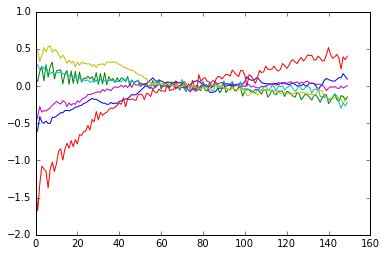

In [229]:
plt.plot(params_full.T)

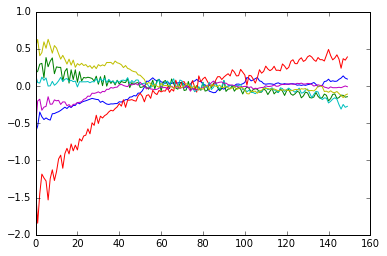

In [388]:
plt.plot(params.T)

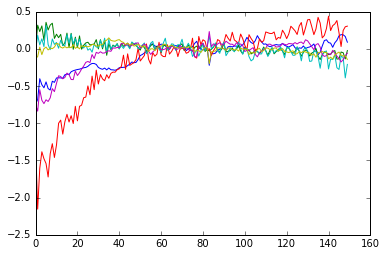

In [230]:
plt.plot(params_downsamp.T)

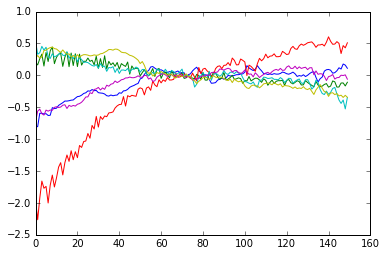

In [181]:
plt.plot(niak_rot_tsl.T)

In [160]:
params[:2,:].shape

(2, 150)

In [143]:
import scipy.io as sio
sio.savemat('',{'transf':ln_motion_affine})

ValueError: Must pass 2-d input

In [477]:
transf

array([  3.00000004e+00,  -5.41033752e-08,  -5.49852732e-09,
         2.47093813e-07,   7.85398132e-01,  -2.24920620e-07])

In [470]:
aa

array([  3.00000004e+00,  -5.41033752e-08,  -5.49852732e-09,
         2.47093813e-07,   7.85398132e-01,  -2.24920620e-07])

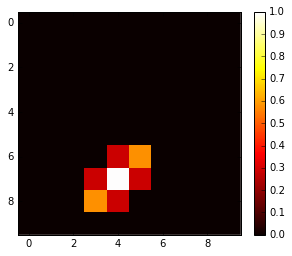

In [471]:
new_vol = aff_trans(aa,*(target,values,v2w_affine,v2w_affine,values.shape))

plt.figure()
visu.mat(new_vol[:,4,:],lim=[0,1])

In [91]:
from scipy.optimize import fmin
def f_(x,*args):
    print x,args
    return abs(5**2-x[0]**x[1])
fmin(f_,[1,1],(1,1))

[ 1.  1.] (1, 1)
[ 1.05  1.  ] (1, 1)
[ 1.    1.05] (1, 1)
[ 1.05  0.95] (1, 1)
[ 1.1   0.95] (1, 1)
[ 1.15   0.925] (1, 1)
[ 1.15   0.975] (1, 1)
[ 1.2     0.9875] (1, 1)
[ 1.3     0.9125] (1, 1)
[ 1.425    0.86875] (1, 1)
[ 1.475    0.93125] (1, 1)
[ 1.6375    0.934375] (1, 1)
[ 1.8625    0.815625] (1, 1)
[ 2.19375    0.7296875] (1, 1)
[ 2.40625    0.7953125] (1, 1)
[ 2.896875    0.75859375] (1, 1)
[ 3.453125    0.55390625] (1, 1)
[ 4.15625    0.5828125] (1, 1)
[ 5.1375    0.509375] (1, 1)
[ 4.58125    0.7140625] (1, 1)
[ 5.1453125   0.79414062] (1, 1)
[ 7.3859375   0.54492187] (1, 1)
[ 7.39375    0.8296875] (1, 1)
[ 8.521875    0.98984375] (1, 1)
[ 6.28125    1.2390625] (1, 1)
[ 5.72890625  1.58613281] (1, 1)
[ 9.10546875  1.78183594] (1, 1)
[ 6.13535156  1.04106445] (1, 1)
[ 8.11542969  1.53491211] (1, 1)
[ 9.10546875  1.78183594] (1, 1)
[ 5.32246094  2.13120117] (1, 1)
[ 6.12231445  1.84586182] (1, 1)
[ 8.50883789  1.79464111] (1, 1)
[ 6.42388916  1.63825989] (1, 1)
[ 7.81385498  

array([ 8.24323428,  1.52597272])

In [61]:
np.eye(4,4).dot(np.eye(4,3).dot(np.array([[np.cos(0.5),-np.sin(0.5),0],[np.sin(0.5),np.cos(0.5),0],[0,0,1]])))

array([[ 0.87758256, -0.47942554,  0.        ],
       [ 0.47942554,  0.87758256,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [19]:
import scipy
scipy.__version__


'0.18.1'

In [396]:
vol.swapaxes

(64, 64, 33, 150)

In [119]:
coreg_mean_vol = []
for ii in range(vol.shape[3]):
    dd = resample_trans(vol.mean(3),vol_nii.affine,vol_nii.affine,vol.shape[:3],affine_trans=npl.inv(ln_motion_affine[:,:,ii]))
    coreg_mean_vol.append(dd)
    #new_img = nib.Nifti1Image(dd,vol_nii.affine)
    
coreg_mean_vol = np.array(coreg_mean_vol)[...,np.newaxis].swapaxes(0,4)[0,...]

In [120]:
coreg_mean_vol.shape

(64, 64, 33, 150)

In [382]:
new_img = nib.Nifti1Image(coreg_mean_vol[0],vol_nii.affine)

In [167]:
npl.inv(tfm)

array([[  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0.,   1., -30.],
       [  0.,   0.,   0.,   1.]])

In [150]:
ln_motion_affine[:,:,ii]

array([[ 0.9999373 , -0.00548315, -0.00976218, -0.80430609],
       [ 0.00542643,  0.99996829, -0.00582724,  0.16427231],
       [ 0.00979382,  0.0057739 ,  0.99993533, -2.26354361],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [183]:
vol_tmp.affine

array([[  3.74900937e+00,   0.00000000e+00,   1.04574092e-01,
         -1.17579018e+02],
       [  4.89537641e-02,   3.08637333e+00,  -2.58368921e+00,
         -3.95849724e+01],
       [ -7.09352046e-02,   2.12997651e+00,   3.74381042e+00,
         -1.07464394e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [184]:
new_img.affine

array([[  3.74834536e+00,   3.76086050e-02,   1.27213553e-01,
         -1.18013409e+02],
       [  2.79862588e-02,   3.09857378e+00,  -2.56256433e+00,
         -3.97151108e+01],
       [ -1.07814404e-01,   2.11185390e+00,   3.75760351e+00,
         -1.03822451e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [159]:
np.dot(npl.inv(ln_motion_affine[:,:,ii]),(vol_nii.affine))

array([[  3.74834536e+00,   3.76086050e-02,   1.27213553e-01,
         -1.18013409e+02],
       [  2.79862588e-02,   3.09857378e+00,  -2.56256433e+00,
         -3.97151108e+01],
       [ -1.07814404e-01,   2.11185390e+00,   3.75760351e+00,
         -1.03822451e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [174]:
print vol_tmp.shape
print new_img.shape

(64, 64, 33)
(64, 69, 39)


(1000, 3) (10, 10, 10)


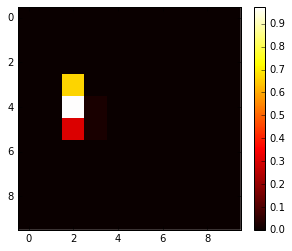

In [370]:
dd = resample_trans(values,vol_nii.affine,vol_nii.affine,values.shape,translation_affine)
visu.mat(dd[:,2,:])

In [14]:
# R2 score
def getR2(y,ypred):
    R2 = 1. - np.sum((y-ypred)**2,0)/np.sum(y**2,0)
    return R2 

def getMap(val,mask):
    if len(val.shape)==2:
        new_map = np.zeros((mask.shape[0],mask.shape[1],mask.shape[2],val.shape[1])).astype(float)
    else:
        new_map = np.zeros_like(mask).astype(float)
    new_map[mask] = val
    return new_map

def getspec(vol):
    nx,ny,nz = vol.shape
    nrows = int(np.ceil(np.sqrt(nz)))
    ncolumns = int(np.ceil(nz/(1.*nrows)))
    return nrows,ncolumns,nx,ny,nz

def montage(vol1):

    vol = np.swapaxes(vol1,0,1)
    nrows,ncolumns,nx,ny,nz = getspec(vol)

    mozaic = np.zeros((nrows*nx,ncolumns*ny))
    indx,indy = np.where(np.ones((nrows,ncolumns)))

    for ii in np.arange(vol.shape[2]):
        # we need to flip the image in the x axis
        mozaic[(indx[ii]*nx):((indx[ii]+1)*nx),(indy[ii]*ny):((indy[ii]+1)*ny)] = vol[::-1,:,ii]

    return mozaic

In [107]:
#new_img = resample_img(vol_tmp,target_affine=np.dot(tfm,vol_nii.affine),target_shape=vol_tmp.shape)
dd = resample_trans(vol_tmp.get_data(),vol_nii.affine,vol_nii.affine,vol_tmp.get_data().shape,tfm)
#dd = resample_trans_ref(vol_tmp.get_data(),vol_nii.affine,vol_nii.affine,vol_tmp.get_data().shape,tfm)
new_img = nib.Nifti1Image(dd,vol_nii.affine)

[[  1.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   1.11022302e-16]
 [  1.73472348e-18   0.00000000e+00   1.00000000e+00]] [ -0.3026564    9.08790054  10.8503134 ]
0.0126988887787


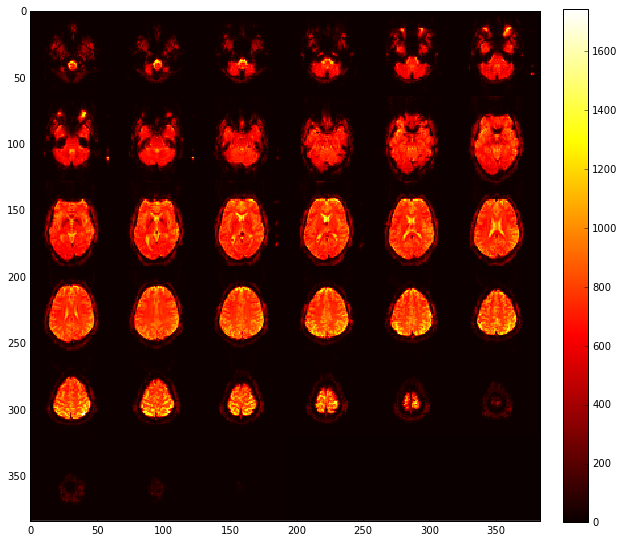

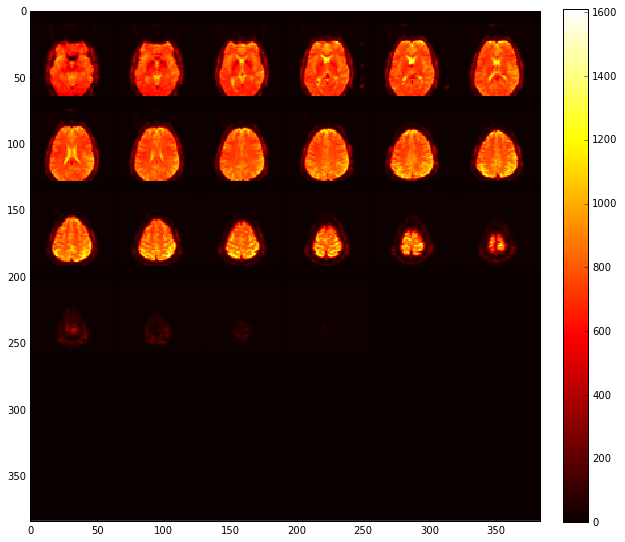

In [108]:
plt.figure(figsize=(10,10))
visu.mat(montage(vol_tmp.get_data()))

plt.figure(figsize=(10,10))
visu.mat(montage(new_img.get_data()))

In [398]:
x=new_img.get_data()[:32,:32,:15]

x.shape

(32, 32, 15)

In [397]:
np.dot(flat_x.T, flat_x)

MemoryError: 

In [401]:
from scipy import linalg
flat_x = np.reshape(x, (1, x.shape[0] * x.shape[1] * x.shape[2]))
print flat_x.shape
sigma = np.dot(flat_x.T, flat_x)
u, s, v = linalg.svd(sigma)
principal_components = np.dot(np.dot(u, np.diag(1. / np.sqrt(s + 10e-7))), u.T)

(1, 15360)


KeyboardInterrupt: 

In [ ]:
flatx = np.reshape(x, (x.size))
whitex = np.dot(flatx, self.principal_components)
x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))

In [122]:
mask_b = compute_epi_mask(vol_nii).get_data().astype(bool)
print mask_b.shape

X = Xmotion
y = vol - coreg_mean_vol
y = y[mask_b].T

lreg_drift = LinearRegression(fit_intercept=True)
lreg_drift.fit(Xdrift,y)
new_y = y-lreg_drift.predict(Xdrift)

lreg_motion = LinearRegression(fit_intercept=True)
lreg_motion.fit(Xdrift,Xmotion)
new_Xmotion = Xmotion - lreg_motion.predict(Xdrift)

lreg = LinearRegression(fit_intercept=False)
lreg.fit(new_Xmotion,new_y)

ypred = lreg.predict(new_Xmotion)
R2 = getR2(new_y,ypred)

print 'Average R2: ',R2.mean()

(64, 64, 33)
Average R2:  0.295714128242


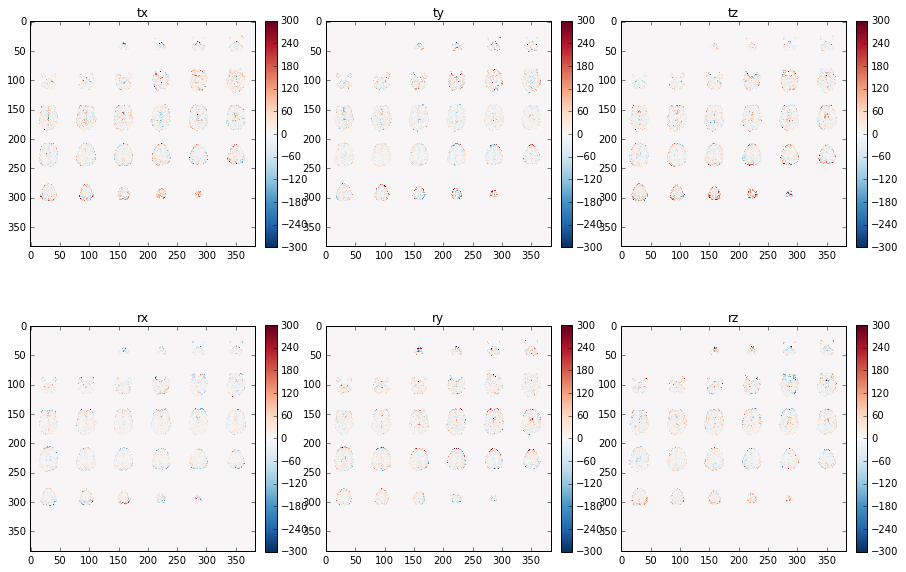

In [123]:
thresh = 300#np.abs(lreg.coef_).max()

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,0]),lim=[-thresh,thresh])
plt.title('tx')
plt.subplot(2,3,2)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,1]),lim=[-thresh,thresh])
plt.title('ty')
plt.subplot(2,3,3)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,2]),lim=[-thresh,thresh])
plt.title('tz')
plt.subplot(2,3,4)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,3]),lim=[-thresh,thresh])
plt.title('rx')
plt.subplot(2,3,5)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,4]),lim=[-thresh,thresh])
plt.title('ry')
plt.subplot(2,3,6)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,5]),lim=[-thresh,thresh])
plt.title('rz')

In [124]:
def show_diff(ref_vals,pred_vals,mask,frame=10,cut=30):
    plt.figure(figsize=(15,5))
    ref_vol = getMap(ref_vals[frame,:],mask)
    lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
    plt.subplot(1,3,1)
    visu.mat(getMap(ref_vals[frame,:],mask)[:,:,cut],lim=lim_val)
    plt.subplot(1,3,2)
    visu.mat(getMap(pred_vals[frame,:],mask)[:,:,cut],lim=lim_val)
    plt.subplot(1,3,3)
    visu.mat(getMap((ref_vals-pred_vals)[frame,:],mask)[:,:,cut],lim=lim_val)
    
def show_report(ref_vals,pred_vals,mask,frames,cut=30):
    n_frames = len(frames)
    # R2
    R2 = getR2(ref_vals,pred_vals)
    
    fig=plt.figure(figsize=(15,5+5*len(frames)))
    ax = plt.subplot(n_frames+1,2,1)
    plt.title('R2 Mean:'+str(round(R2.mean(),3))+' Min:'+str(round(R2.min(),3))+' Max:'+str(round(R2.max(),3)))
    visu.mat(getMap(R2,mask)[:,:,cut],lim=[-1,1])
    plt.subplot(n_frames+1,2,2)
    plt.title('R2 distribution')
    plt.hist(R2,100)
    
    # frames
    for ii in range(n_frames):
        ref_vol = getMap(ref_vals[frames[ii],:],mask)
        lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
        plt.subplot(n_frames+1,3,3+3*ii+1)
        visu.mat(getMap(ref_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Reference')
        plt.ylabel('Frame '+str(frames[ii]))
        plt.subplot(n_frames+1,3,3+3*ii+2)
        visu.mat(getMap(pred_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Prediction')
        plt.subplot(n_frames+1,3,3+3*ii+3)
        visu.mat(getMap((ref_vals-pred_vals)[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Difference')
    